In [1]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings
#used for plots
from scipy import stats
from mplsoccer import PyPizza, FontManager

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [2]:
train = pd.DataFrame()
for i in range(13):
    file_name = 'events_England_' + str(i+1) + '.json'
    path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'socceranalytics', 'Wyscout', file_name)

    with open(path) as f:
        data = json.load(f)
    train = pd.concat([train, pd.DataFrame(data)], ignore_index = True)
#potential data collection error handling


In [3]:
train.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


In [4]:
train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643032 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643032 non-null  int64  
 1   subEventName  643032 non-null  object 
 2   tags          643032 non-null  object 
 3   playerId      643032 non-null  int64  
 4   positions     643032 non-null  object 
 5   matchId       643032 non-null  int64  
 6   eventName     643032 non-null  object 
 7   teamId        643032 non-null  int64  
 8   matchPeriod   643032 non-null  object 
 9   eventSec      643032 non-null  float64
 10  subEventId    643032 non-null  object 
 11  id            643032 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 63.8+ MB


# xG Calculation

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

def prepare_data(df):
        X = df[["Distance", "Angle"]]
        y = df["Goal"]
        return X, y

def calculatexG(df, npxG):
    
    
    shots = df.loc[df['eventName'] == "Shot"].copy()
    shots["X"] = shots.positions.apply(lambda cell : (100 - cell[0]['x']) * 105/100)
    shots["Y"] = shots.positions.apply(lambda cell : (cell[0]['y']) * 68/100)
    shots["C"] = shots.positions.apply(lambda cell : abs(50-cell[0]['y']) * 68/100)
    
    
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
    shots["Goal"] = shots.tags.apply(lambda tag : 1 if {'id': 101} in tag else 0)
    headers = shots.loc[shots.apply(lambda x: {'id':403} in x.tags, axis = 1)]
    non_headers = shots.drop(headers.index)
    
    X_nonheaders, y_nonheaders = prepare_data(non_headers)
    X_headers, y_headers = prepare_data(headers)
    
    nonheaders_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    nonheaders_model.fit(X_nonheaders, y_nonheaders)
    non_headers["xG"] = nonheaders_model.predict_proba(X_nonheaders)[:, 1]

    # Train XGBoost model for headers
    headers_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    headers_model.fit(X_headers, y_headers)
    headers["xG"] = headers_model.predict_proba(X_headers)[:, 1]

    if npxG == False:
        penalties = df.loc[df["subEventName"] == "Penalty"]
        penalties = penalties.assign(xG = 0.8)
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]], penalties[["playerId", "xG"]]])
        xG_sum = all_shots_xg.groupby(["playerId"])["xG"].sum().sort_values(ascending = False).reset_index()
    
    else:
        all_shots_xg = pd.concat([non_headers[["playerId", "xG"]], headers[["playerId", "xG"]]])
        all_shots_xg.rename(columns = {"xG": "npxG"}, inplace = True)
        xG_sum = all_shots_xg.groupby(["playerId"])["npxG"].sum().sort_values(ascending = False).reset_index()
  
    
    return xG_sum
                                     

In [7]:
npxg = calculatexG(train, True)
npxg.head()

,playerId,npxG
0,8717,23.478079
1,120353,18.238491
2,11066,15.480752
3,7905,13.646793
4,8325,12.854296


## Final Third Pass Entries and Reception

In [8]:
train_pass = train.loc[train["eventName"] == "Pass"]
train_pass.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


In [9]:
train_pass["nextPlayerId"] = train_pass["playerId"].shift(-1)
train_pass.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextPlayerId
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,370224.0
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,3319.0
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,120339.0
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,167145.0
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,3319.0


In [10]:
def FinalThird(df):
    df = df.copy()
    df["nextPlayerId"] = df["playerId"].shift(-1)
    passes = df.loc[train["eventName"] == "Pass"].copy()
    
    passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x'] * 105/100))
    passes["y"] = passes.positions.apply(lambda cell: (cell[0]['y'] * 68/100))
    passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x'] * 105/100))
    passes["end_y"] = passes.positions.apply(lambda cell: (cell[1]['y'] * 68/100))
    
    accurate_passes = passes.loc[passes.apply(lambda x: {'id': 1801} in x.tags, axis = 1)]
    final_third_passes = accurate_passes.loc[accurate_passes["end_x"] > 2*105/3]
    
    ftp_player = final_third_passes.groupby(["playerId"]).end_x.count().reset_index()
    ftp_player.rename(columns = {'end_x': 'final_third_passes'}, inplace = True)
    
    rtp_player = final_third_passes.groupby(["nextPlayerId"]).end_x.count().reset_index()
    rtp_player.rename(columns = {'end_x': 'final_third_receptions', 'nextPlayerId': 'playerId'}, inplace = True)
    
    final_third = ftp_player.merge(rtp_player, how = "outer", on = ["playerId"])
    return final_third

In [11]:
final_third = FinalThird(train)
final_third.head()

,playerId,final_third_passes,final_third_receptions
0,36.0,186.0,83.0
1,38.0,62.0,66.0
2,48.0,392.0,188.0
3,54.0,818.0,800.0
4,56.0,27.0,29.0


## Air and Ground Duels 

In [12]:
def wonDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won air and ground duels for a player

    """
    #find air duels
    air_duels = df.loc[df["subEventName"] == "Air duel"]
    #703 is the id of a won duel
    won_air_duels = air_duels.loc[air_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]

    #group and sum air duels
    wad_player =  won_air_duels.groupby(["playerId"]).eventId.count().reset_index()
    wad_player.rename(columns = {'eventId':'air_duels_won'}, inplace=True)

    #find ground duels won
    ground_duels = df.loc[df["subEventName"].isin(["Ground attacking duel"])]
    won_ground_duels = ground_duels.loc[ground_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]

    wgd_player =  won_ground_duels.groupby(["playerId"]).eventId.count().reset_index()
    wgd_player.rename(columns = {'eventId':'ground_duels_won'}, inplace=True)

    #outer join
    duels_won = wgd_player.merge(wad_player, how = "outer", on = ["playerId"])
    return duels_won

duels = wonDuels(train)
#investigate structure
duels.head(3)

,playerId,ground_duels_won,air_duels_won
0,0,2244.0,1061.0
1,36,13.0,23.0
2,38,7.0,11.0


## Smart Passes

In [13]:
def smartPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    sp_player: dataframe
        dataframe with number of smart passes.

    """
    #get smart passes
    smart_passes = df.loc[df["subEventName"] == "Smart pass"]
    #find accurate
    smart_passes_made = smart_passes.loc[smart_passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]

    #sum by player
    sp_player =  smart_passes_made.groupby(["playerId"]).eventId.count().reset_index()
    sp_player.rename(columns = {'eventId':'smart_passes'}, inplace=True)

    return sp_player

smart_passes = smartPasses(train)
#investigate structure
smart_passes.head(3)


,playerId,smart_passes
0,36,1
1,38,1
2,48,3


In [14]:
def GoalsAssistsKeyPasses(df):
    
    
    #get goals
    shots = df.loc[df["subEventName"] == "Shot"]
    goals = shots.loc[shots.apply (lambda x:{'id':101} in x.tags, axis = 1)]
    
    #get assists
    passes = df.loc[df["eventName"] == "Pass"]
    assists = passes.loc[passes.apply (lambda x:{'id':301} in x.tags, axis = 1)]
    
    #get key passes
    key_passes = passes.loc[passes.apply (lambda x:{'id':302} in x.tags, axis = 1)]

    #goals by player
    g_player =  goals.groupby(["playerId"]).eventId.count().reset_index()
    g_player.rename(columns = {'eventId':'goals'}, inplace=True)

    #assists by player
    a_player =  assists.groupby(["playerId"]).eventId.count().reset_index()
    a_player.rename(columns = {'eventId':'assists'}, inplace=True)

    #key passes by player
    kp_player =  key_passes.groupby(["playerId"]).eventId.count().reset_index()
    kp_player.rename(columns = {'eventId':'key_passes'}, inplace=True)

    data = g_player.merge(a_player, how = "outer", on = ["playerId"]).merge(kp_player, how = "outer", on = ["playerId"])
    return data

gakp = GoalsAssistsKeyPasses(train)
#investigate structure
gakp.head(3)

,playerId,goals,assists,key_passes
0,54,10.0,5.0,25.0
1,74,1.0,NaN,1.0
2,93,2.0,5.0,14.0


In [15]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'socceranalytics', 'Wyscout', 'minutes_played_per_game_England.json')

with open(path) as f:
    minutes_per_game = json.load(f)

minutes_per_game = pd.DataFrame(minutes_per_game)
minutes_per_game.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10443 entries, 0 to 10442
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   playerId        10443 non-null  int64 
 1   shortName       10443 non-null  object
 2   matchId         10443 non-null  int64 
 3   teamId          10443 non-null  int64 
 4   teamName        10443 non-null  object
 5   player_in_min   10443 non-null  int64 
 6   player_out_min  10443 non-null  int64 
 7   minutesPlayed   10443 non-null  int64 
 8   red_card        10443 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 815.9+ KB


In [16]:
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

In [17]:
minutes.head()

,playerId,minutesPlayed
0,36,1238
1,38,382
2,48,3343
3,54,3348
4,56,266


In [18]:
players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])
summary = summary.merge(npxg, how = "left", on = ["playerId"]).merge(final_third, how = "left", on = ["playerId"]).merge(duels, how = "left", on = ["playerId"]).merge(smart_passes, how = "left", on = ["playerId"]).merge(gakp, how = "left", on = ["playerId"])

summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]


In [19]:
summary.head()

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes
0,36,1238,0.659786,186.0,83.0,13.0,23.0,1.0,0.0,0.0,2.0
2,48,3343,1.160313,392.0,188.0,50.0,137.0,3.0,0.0,0.0,3.0
3,54,3348,6.824480,818.0,800.0,102.0,15.0,42.0,10.0,5.0,25.0
5,74,1514,0.469453,115.0,41.0,14.0,48.0,4.0,1.0,0.0,1.0
6,93,2942,2.753708,265.0,365.0,141.0,42.0,7.0,2.0,5.0,14.0


## Minutes Played

In [20]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]),'socceranalytics', 'Wyscout', 'players.json')
with open(path) as f:
    players = json.load(f)
player_df = pd.DataFrame(players)
forwards = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Forward", axis = 1)]
forwards.rename(columns = {'wyId':'playerId'}, inplace=True)
to_merge = forwards[['playerId', 'shortName']]
summary = summary.merge(to_merge, how = "inner", on = ["playerId"])

In [21]:
summary.head()

,playerId,minutesPlayed,npxG,final_third_passes,final_third_receptions,ground_duels_won,air_duels_won,smart_passes,goals,assists,key_passes,shortName
0,471,756,1.785848,39.0,69.0,37.0,48.0,4.0,2.0,0.0,1.0,W. Bony
1,3324,2143,9.554943,199.0,340.0,170.0,48.0,9.0,11.0,4.0,6.0,\u00c1lvaro Morata
2,3326,618,0.723410,43.0,81.0,33.0,0.0,3.0,1.0,1.0,3.0,Jes\u00e9 Rodr\u00edguez
3,3327,1775,5.968680,133.0,175.0,50.0,134.0,3.0,4.0,1.0,4.0,Joselu
4,3348,441,0.559254,49.0,69.0,31.0,0.0,4.0,1.0,0.0,1.0,Deulofeu


In [22]:
player_df

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598,"{'name': 'Tunisia', 'id': 788, 'alpha3code': '...",72,Ali,,Ma\u00e2loul,16041,1990-01-01,175,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Tunisia', 'id': 788, 'alpha3code': '...",120839,left,A. Ma\u00e2loul,null
3599,"{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",76,Carlos Alberto,,C\u00e1ceda Oyaguez,15591,1991-09-27,183,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",114736,right,C. C\u00e1ceda,null
3600,"{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",78,Miguel Gianpierre,,Araujo Blanco,12072,1994-10-24,179,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Peru', 'id': 604, 'alpha3code': 'PER...",114908,right,M. Araujo,null
3601,"{'name': 'Morocco', 'id': 504, 'alpha3code': '...",70,Ahmed Reda,,Tagnaouti,16183,1996-04-05,182,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Morocco', 'id': 504, 'alpha3code': '...",285583,right,A. Tagnaouti,null


In [23]:
summary_per_90 = pd.DataFrame()
summary_per_90["shortName"] = summary["shortName"]
for column in summary.columns[2:-1]:
    summary_per_90[column + "_per90"] = summary.apply(lambda x: x[column]*90/x["minutesPlayed"], axis = 1)

In [24]:
summary_per_90[summary_per_90["shortName"].str.contains("Salah", case = False)]

,shortName,npxG_per90,final_third_passes_per90,final_third_receptions_per90,ground_duels_won_per90,air_duels_won_per90,smart_passes_per90,goals_per90,assists_per90,key_passes_per90
61,Mohamed Salah,0.548068,12.681135,18.631052,5.979967,0.300501,0.751252,0.931553,0.210351,0.330551


## Percentile Stats for Salah

In [25]:
salah = summary_per_90.loc[summary_per_90["shortName"] == "Mohamed Salah"]

In [26]:
salah = salah[['npxG_per90', "goals_per90", "assists_per90", "key_passes_per90", "smart_passes_per90", "final_third_passes_per90", "final_third_receptions_per90", "ground_duels_won_per90", "air_duels_won_per90"]]

In [27]:
per_90_columns = salah.columns[:]
values = [round(salah[column].iloc[0],2) for column in per_90_columns]
percentiles = [int(stats.percentileofscore(summary_per_90[column], salah[column].iloc[0])) for column in per_90_columns]

In [28]:
percentiles

[97, 100, 90, 67, 89, 86, 90, 69, 13]

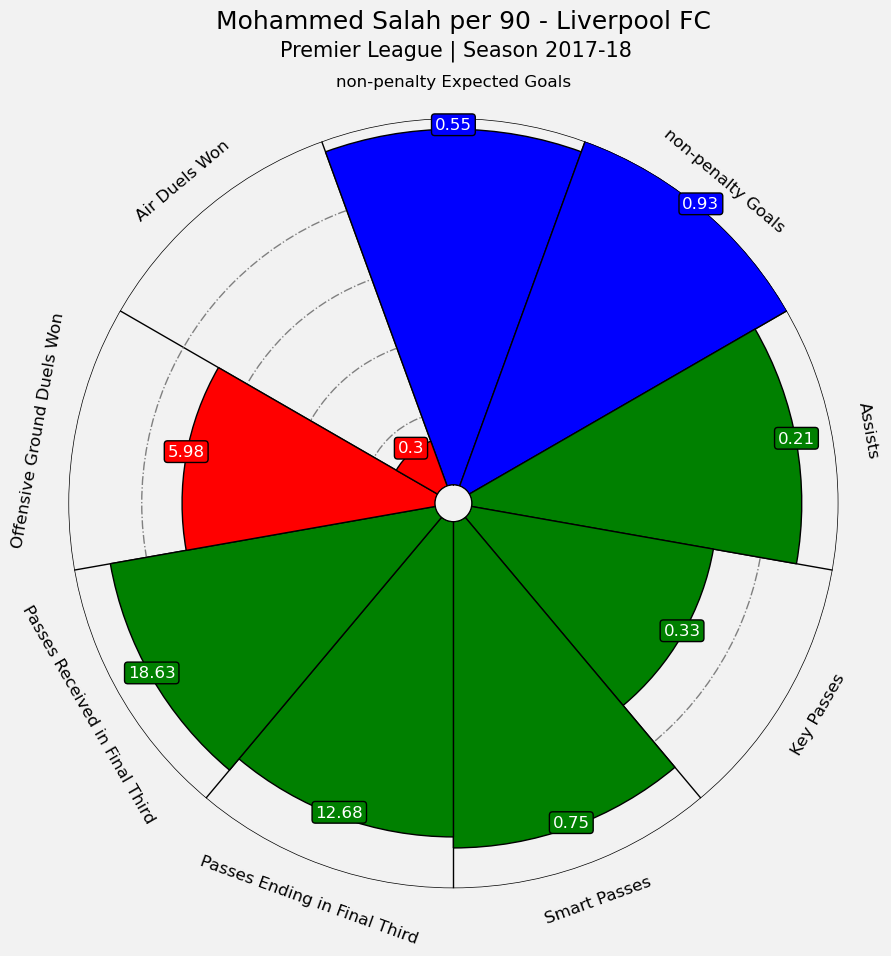

In [29]:
#list of names on plots
names = ["non-penalty Expected Goals", "non-penalty Goals", "Assists", "Key Passes", "Smart Passes", "Passes Ending in Final Third", "Passes Received in Final Third", "Offensive Ground Duels Won", "Air Duels Won"]
slice_colors = ["blue"] * 2 + ["green"] * 5 + ["red"] * 2
text_colors = ["white"]*9

#PIZZA PLOT
baker = PyPizza(
    params=names,
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.275, 0.97, "Mohammed Salah per 90 - Liverpool FC", size=18
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Premier League | Season 2017-18",
    size=15,
    ha="center", color="#000000"
)
plt.show()


## Possession Adjusted

In [30]:
possesion_dict = {}
#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possesion_dict.keys():
        possesion_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    min_in = row["player_in_min"]*60
    min_out = row["player_out_min"]*60

    #get the dataframe of events from the game
    match_df = train.loc[train["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] = match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1]
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"].isin(["Air duel", "Ground defending duel","Ground loose ball duel"])].loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)
    #take team passes
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possesion_dict[str(player_id)]["team_passes"] += len(team_passes)
    possesion_dict[str(player_id)]["all_passes"] += len(all_passes)

#calculate possesion for each player
percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possesion_dict.items()}
#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "possesion"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])


In [31]:
#create a new dataframe only for it
summary_adjusted = pd.DataFrame()
summary_adjusted["shortName"] = summary["shortName"]
#calculate value adjusted
for column in summary.columns[2:11]:
    summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column]/x["possesion"])*90/x["minutesPlayed"], axis = 1)

In [32]:
summary_adjusted.head()

,shortName,npxG_adjusted_per90,final_third_passes_adjusted_per90,final_third_receptions_adjusted_per90,ground_duels_won_adjusted_per90,air_duels_won_adjusted_per90,smart_passes_adjusted_per90,goals_adjusted_per90,assists_adjusted_per90,key_passes_adjusted_per90
0,W. Bony,0.460443,10.055333,17.790205,9.539675,12.375795,1.031316,0.515658,0.000000,0.257829
1,\u00c1lvaro Morata,0.716398,14.920356,25.492065,12.746032,3.598880,0.674790,0.824743,0.299907,0.449860
2,Jes\u00e9 Rodr\u00edguez,0.259475,15.423409,29.053398,11.836570,0.000000,1.076052,0.358684,0.358684,1.076052
3,Joselu,0.721035,16.066810,21.140539,6.040154,16.187613,0.362409,0.483212,0.120803,0.483212
4,Deulofeu,0.235933,20.671673,29.109090,13.077997,0.000000,1.687484,0.421871,0.000000,0.421871


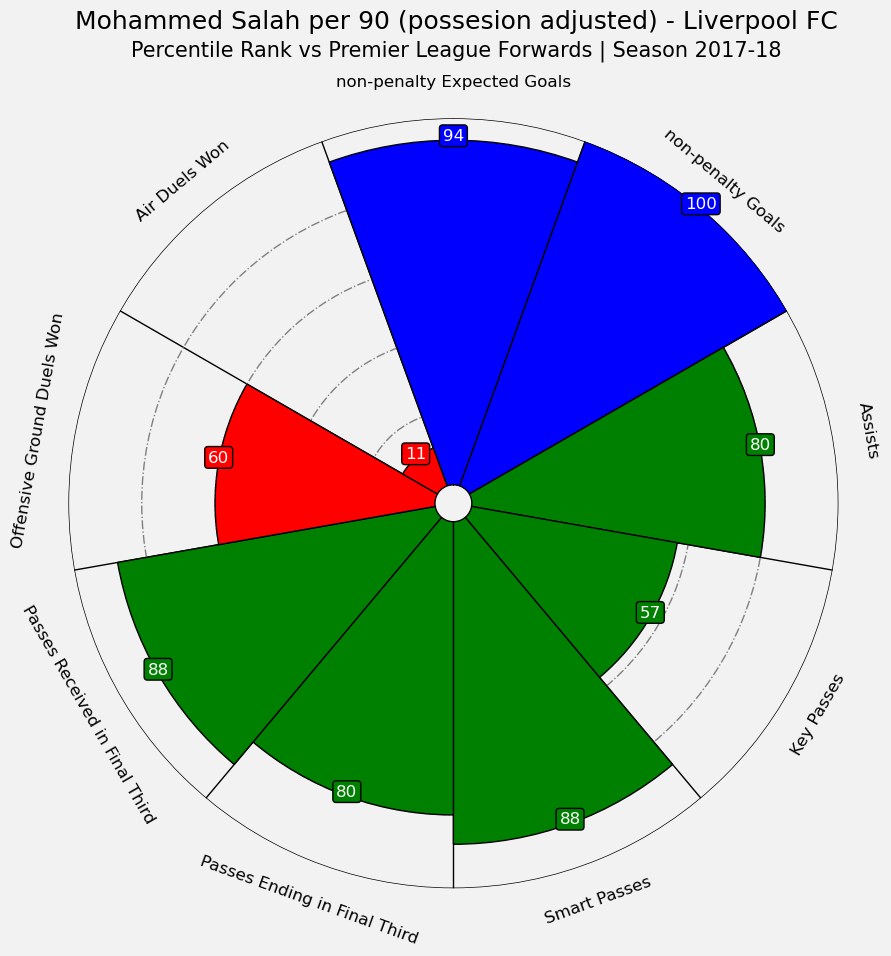

In [33]:
salah_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == "Mohamed Salah"]
salah_adjusted = salah_adjusted[['npxG_adjusted_per90', "goals_adjusted_per90", "assists_adjusted_per90", "key_passes_adjusted_per90", "smart_passes_adjusted_per90", "final_third_passes_adjusted_per90", "final_third_receptions_adjusted_per90", "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]]
#take only necessary columns
adjusted_columns = salah_adjusted.columns[:]
#values
values = [salah_adjusted[column].iloc[0] for column in adjusted_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], salah_adjusted[column].iloc[0])) for column in adjusted_columns]
names = names = ["non-penalty Expected Goals", "non-penalty Goals", "Assists", "Key Passes", "Smart Passes", "Passes Ending in Final Third", "Passes Received in Final Third", "Offensive Ground Duels Won", "Air Duels Won"]


baker = PyPizza(
    params=names,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
         va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, "Mohammed Salah per 90 (possesion adjusted) - Liverpool FC", size=18,
    ha="center", color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Premier League Forwards | Season 2017-18",
    size=15,
    ha="center",  color="#000000"
)

plt.show()


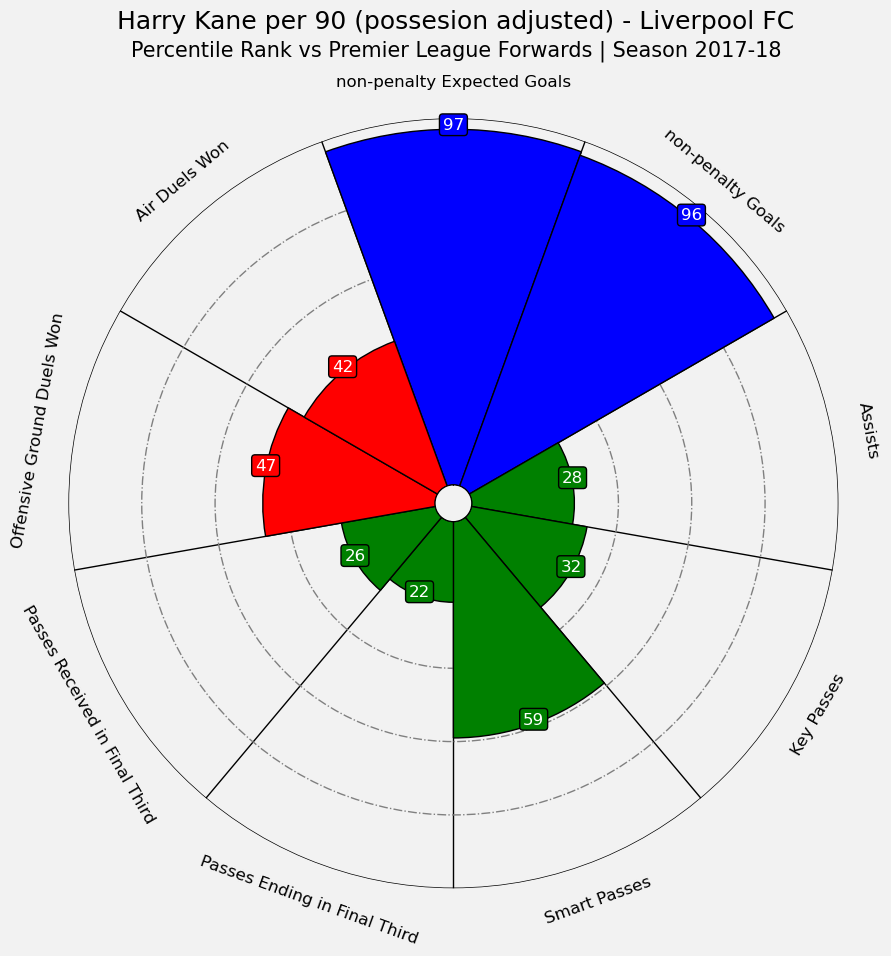

In [34]:
kane_adjusted = summary_adjusted.loc[summary_adjusted["shortName"].str.contains("Kane", case = False, na= False)]
kane_adjusted = kane_adjusted[['npxG_adjusted_per90', "goals_adjusted_per90", "assists_adjusted_per90", "key_passes_adjusted_per90", "smart_passes_adjusted_per90", "final_third_passes_adjusted_per90", "final_third_receptions_adjusted_per90", "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]]
#take only necessary columns
adjusted_columns = kane_adjusted.columns[:]
#values
values = [kane_adjusted[column].iloc[0] for column in adjusted_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], kane_adjusted[column].iloc[0])) for column in adjusted_columns]
names = names = ["non-penalty Expected Goals", "non-penalty Goals", "Assists", "Key Passes", "Smart Passes", "Passes Ending in Final Third", "Passes Received in Final Third", "Offensive Ground Duels Won", "Air Duels Won"]


baker = PyPizza(
    params=names,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
         va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, "Harry Kane per 90 (possesion adjusted) - Liverpool FC", size=18,
    ha="center", color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Premier League Forwards | Season 2017-18",
    size=15,
    ha="center",  color="#000000"
)

plt.show()
